# Nowcasting methods - part 1 deterministic forecasts

In this notebook we show how to construct, visualize, apply verification metrics to and export deterministic nowcasts using pysteps.


## Load the data and pre-processing steps from the previous exercises

First, we load the data and apply the pre-processing steps from the previous exercices, so that we can use it in this notebook.
Start with loading the data below.

In [1]:
import xarray as xr
import pandas as pd

def load_opensense_dataset(filename, rain_variable_name="rainfall_amount", **kwargs):
    """Load dataset processed in the OpenSense training school."""

    ds = xr.open_dataset(filename)

    data = ds[rain_variable_name].data
    timestamps = pd.to_datetime(ds.time.values).to_pydatetime()
    timestep = (timestamps[1] - timestamps[0]).total_seconds() / 60

    if 'x' not in ds.dims:
        xpixelsize = abs(ds.lon[1].values - ds.lon[0].values)
    else:
        xpixelsize = abs(ds.lon.diff(dim="x").isel(x=0, y=0).item())

    if 'y' not in ds.dims:
        ypixelsize = abs(ds.lat[1].values - ds.lat[0].values)
    else:
        ypixelsize = ds.lat.diff(dim="y").isel(x=0, y=0).item()

    metadata = {
        'accutime': 15,
         'institution': ds.attrs["institution"],
         'product': 'AQC',
        #  The data is a lon-lat grid, so the projection is EPSG:4326
         'projection': 'EPSG:4326',
         'cartesian_unit': 'degree',
         'threshold': 0,
         'timestamps': timestamps,
         'transform': None,
         'unit': 'mm',
         'x1': ds.lon.min().item(),
         'x2': ds.lon.max().item(),
         'xpixelsize': xpixelsize,
         'y1': ds.lat.min().item(),
         'y2': ds.lat.max().item(),
         'yorigin': 'lower',
         'ypixelsize': ypixelsize,
         'zerovalue': 0,
         'zr_a': 316.0,
         'zr_b': 1.5,
    }

    return data, metadata, timestep

In [2]:
# Replace the path with the path to the OpenSense dataset
filename = "../../../../data/radar_gauge_3days_period1.nc"

# Load the dataset using the function
precip, metadata, timestep = load_opensense_dataset(filename)

Then, we add the pre-processing steps, which consist of:
- Conversion of the data from mm to mm/h.
- Transformation of the data, here we apply a log-transform of the data to dBR with threshold of 0.1 mm/h and fill value of -15 dBR. This improves the reliability of optical flow and nowcasting methods.
- Determining the motion fields with one of the optical flow algorithms. Lucas-Kanade ("LK") is used here. 

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from pysteps import motion
from pysteps.utils import conversion, transformation

# Handling of NaN values has been explicitly implemented in Lucas-Kanade and VET,
# but not in DARTS. For this reason, we set all non-finite values to the minimum
# value before applying the optical flow.
precip_finite = precip.copy()
precip_finite[~np.isfinite(precip_finite)] = np.nanmin(precip)

# First transform the precip from mm to mm/h
precip_mmh, metadata_mmh = conversion.to_rainrate(precip_finite, metadata)

# Select an index (=timestep) for which we are making the nowcasts.
# Store the twelve timesteps after it as observations, which we will use for the
# visualization and validation of the nowcasts.
index = 132
precip_obs_mmh = precip_mmh[index:]

# Then, log-transform the data to dBR with threshold of 0.1 mm/h and fill value of
# -15 dBR
precip_dbr, metadata_dbr = transformation.dB_transform(
    precip_mmh,
    metadata_mmh,
    threshold=0.1,
    zerovalue=-15.0
)

# Use get_method to get a callable function for the chosen method
oflow = motion.get_method("LK")

# Use 4 most recent precipitation fields (60 minutes) for Lucas-Kanade
# Disable printing with verbose=False
advection_field = oflow(precip_dbr[index-4:index], verbose=False)

Pysteps configuration file found at: /home/ritvanen/.pysteps/pystepsrc



# Deterministic nowcasts
In the deterministic nowcasting part, we will use the loaded data (see above) to create a precipitation nowcast and calculate different verification metrics to assess the skill of the nowcast compared to observations.

The first step is to make a nowcast using the **extrapolation** nowcasting method that simply extrapolates the last observed precipitation field along the motion field. You can follow the example in the [PySTEPS example gallery](https://pysteps.readthedocs.io/en/stable/auto_examples/plot_extrapolation_nowcast.html#sphx-glr-auto-examples-plot-extrapolation-nowcast-py). Calculate the nowcasts for 4 leadtimes, i.e. for 1 hour, and visualize some nowcasts with the observations. This approach is similar to what you already have done in [exercise_03](./exercise_03_optical_flow_and_extrapolation.md).

The semi-Lagrangian extrapolation method has some keyword arguments that can improve the quality of the nowcast depending on the data. For a full list of the arguments, see the [pySTEPS documentation](https://pysteps.readthedocs.io/en/latest/generated/pysteps.extrapolation.semilagrangian.extrapolate.html). Feel free to play with it!

Below the simple extrapolation-based nowcast, this notebook also shows how you can make a deterministic nowcast using te S-PROG models. You could try it out yourself with the LINDA model as well, but not that LINDA requires the python package `skimage`. 


In [4]:
from matplotlib import pyplot as plt

from pysteps import nowcasts
from pysteps.visualization import plot_precip_field
%matplotlib inline

# Set nowcast parameters
n_leadtimes = 12

# The extrapolation method has some keyword arguments that can be used to control the nowcasting
extrap_kwargs = {
  "allow_nonfinite_values": False,
  "interp_order": 1,
}

# The extrapolation nowcast
nowcast_method = nowcasts.get_method("extrapolation")
precip_extrap = nowcast_method(
    precip_dbr[index-1, :, :].squeeze(),
    advection_field,
    timesteps=n_leadtimes,
    extrap_method="semilagrangian",
    extrap_kwargs=extrap_kwargs,
)

# Back-transform the results from dBR to rain rates
precip_extrap = transformation.dB_transform(
    precip_extrap,
    threshold=metadata_dbr["threshold"],
    inverse=True
    )[0]

# Calculate the S-PROG nowcast for comparison
# S-PROG requires as many input fields as 1 + degree of the AR process
# and some other arguments
nowcast_method = nowcasts.get_method("sprog")
precip_sprog = nowcast_method(
    precip_dbr[index-3:index, :, :],
    advection_field,
    timesteps=n_leadtimes,
    n_cascade_levels=6,
    precip_thr=metadata_dbr["threshold"],
)
# Back-transform the results from dBR to rain rates
precip_sprog = transformation.dB_transform(
    precip_sprog,
    threshold=metadata_dbr["threshold"],
    inverse=True
    )[0]

Computing S-PROG nowcast
------------------------

Inputs
------
input dimensions: 290x373

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -10.0
Rain fraction is: 0.46829373516994854, while minimum fraction is 0.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.960731      | 0.895812      |
-----------------------------------------
| 2     | 0.753189      | 0.540003      |
------------------------------------

### Visualize the results

Visualize the observations and the nowcasts for a few lead times. An example on how to do this is provided in [the STEPS nowcast gallery example](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_steps_nowcast.html#stochastic-nowcast-with-steps). You can plot the observations on one row and the corresponding nowcasts below them.

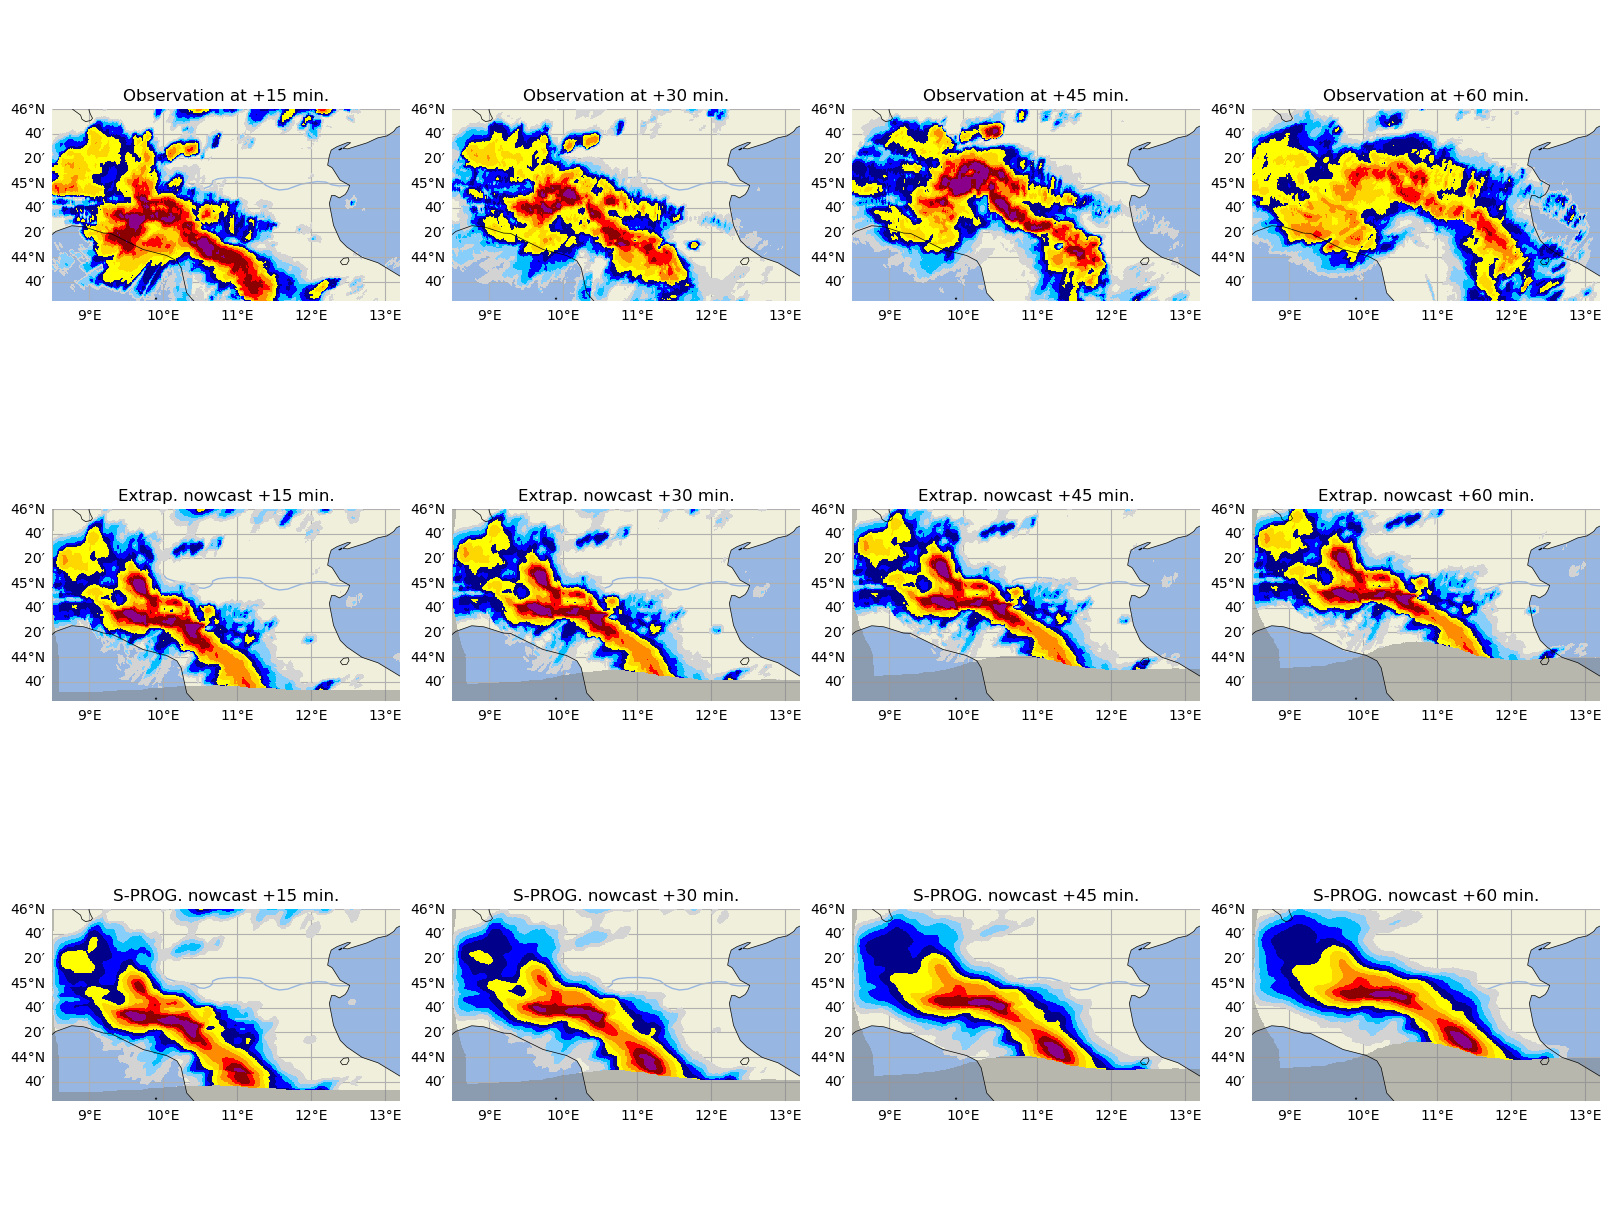

In [5]:
fig = plt.figure(figsize=(16, 12), layout="constrained")
map_kwargs = {"drawlonlatlines": True}

# The nowcasts were made up to 3 hours into the future, so feel free to adjust the plotting
# indices and plot e.g. up to 3 hours instead of up to 1 hour.
for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(3, 4, 1 + i); ax.axis("off")
    plot_precip_field(
        precip_obs_mmh[j],
        geodata=metadata,
        colorscale="STEPS-NL",
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Observation at +{(j + 1) * 15} min."
        )

# We'll plot the nowcast for four lead times
for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(3, 4, 5 + i); ax.axis("off")
    plot_precip_field(
        precip_extrap[j],
        geodata=metadata,
        colorscale="STEPS-NL",
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Extrap. nowcast +{(j + 1) * 15} min."
        )

for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(3, 4, 9 + i); ax.axis("off")
    plot_precip_field(
        precip_sprog[j],
        geodata=metadata,
        colorscale="STEPS-NL",
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"S-PROG. nowcast +{(j + 1) * 15} min."
        )


### Deterministic nowcast verification

Deterministic nowcasts can be verified with pySTEPS using different kind of metrics: continuous, categorical, spatial and SAL scores.

* `pysteps.verification.detcatscores` contains methods to calculate categorical metrics, i.e. metrics calculated for some rain rate thresholds, for example probability of detection (POD) and false alarm ratio (FAR).
* `pysteps.verification.detcontscores` contains methods to calculate continuous verification metrics, for example mean absolute error (MAE).
* `pysteps.verification.spatialscores` contains methods for calculating the Fractions Skill Score (FSS) and the Binary mean squared error (BMSE).
* `pysteps.verification.salscores` contains methods for calculating the Spatial-Amplitude-Location (SAL) score defined by Wernli et al. (2008)

We will calculate probability of detection (POD), false alarm ratio (FAR), equitable threat score (ETS), and the mean error (ME) for the nowcast as a function of leadtime, and visualize them. In this example, we use a threshold of 1.0 mm/h. Feel free to play around with lower and higher thresholds, and see what the effects of different thresholds are on the results you see.

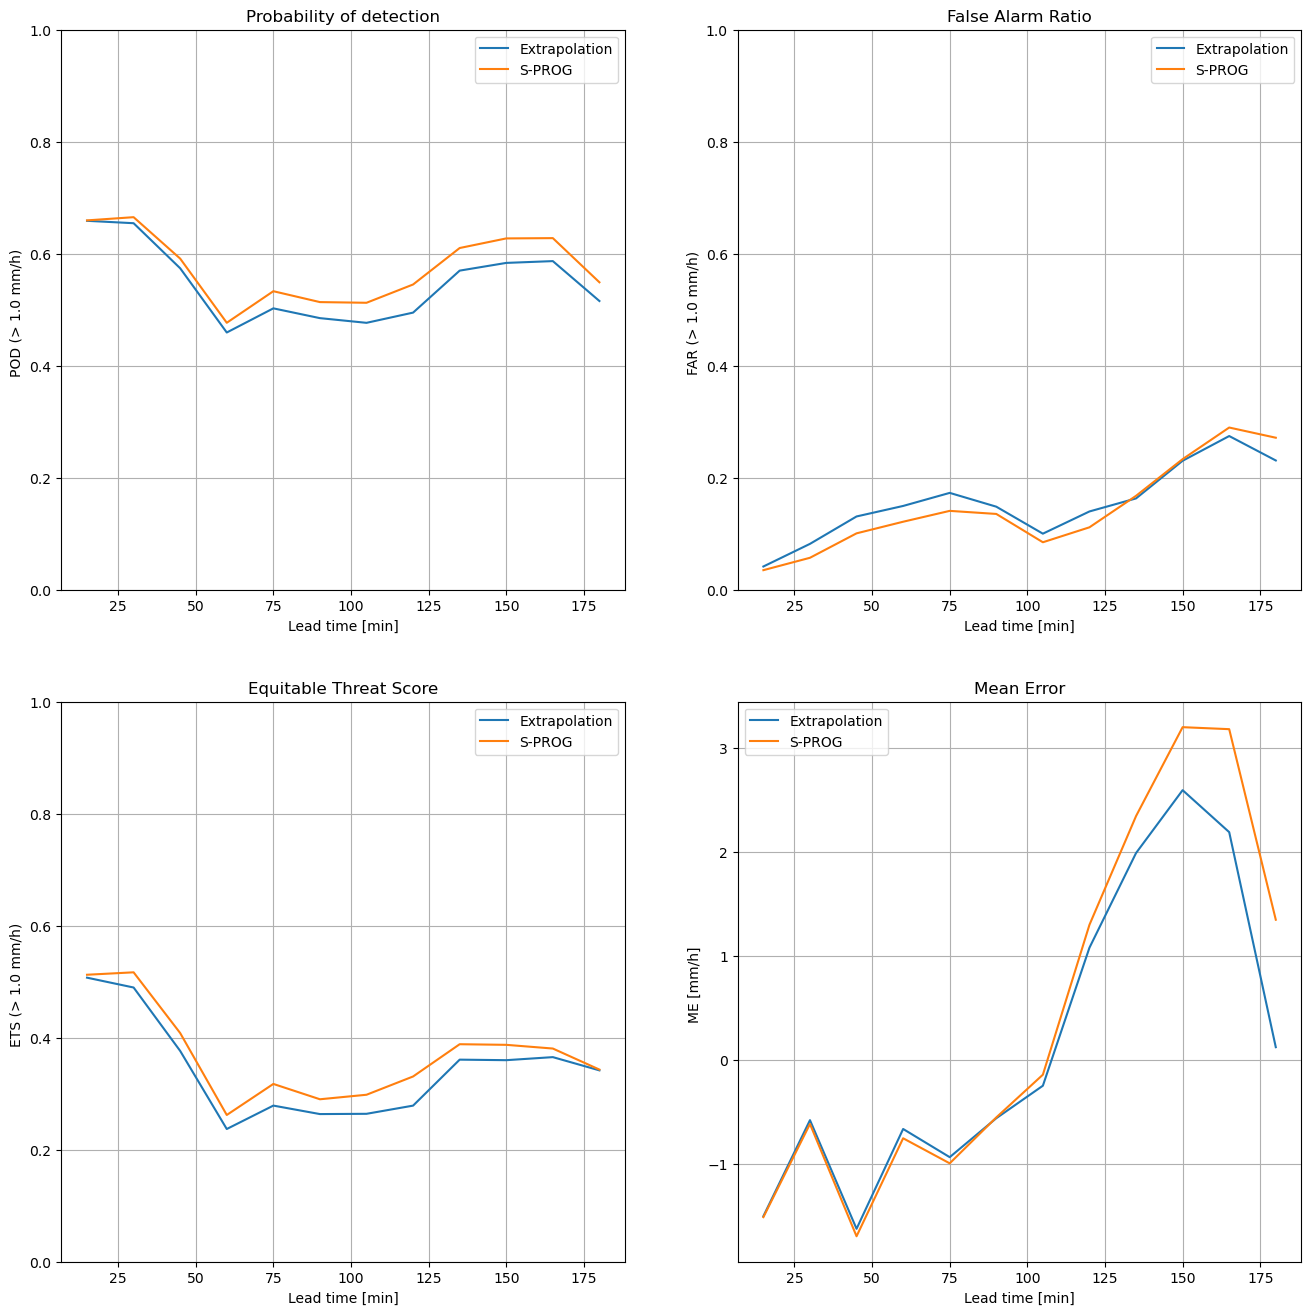

In [6]:
from collections import defaultdict
from pysteps import verification

thr = 1.0
cat_scores = ["POD", "FAR", "ETS"]
cont_scores = ["ME", ]
score = []
score_baseline = []
score_sprog = []
score_steps = []

# Calculate scores for each leadtime
cat_extrap_scores = defaultdict(list)
cat_sprog_scores = defaultdict(list)
cont_extrap_scores = defaultdict(list)
cont_sprog_scores = defaultdict(list)

for i in range(n_leadtimes):
    extrap_score = verification.detcatscores.det_cat_fct(precip_extrap[i], precip_obs_mmh[i], thr=thr, scores=cat_scores)
    sprog_score = verification.detcatscores.det_cat_fct(precip_sprog[i], precip_obs_mmh[i], thr=thr, scores=cat_scores)

    for name in cat_scores:
        cat_extrap_scores[name].append(extrap_score[name])
        cat_sprog_scores[name].append(sprog_score[name])

    extrap_score = verification.detcontscores.det_cont_fct(precip_extrap[i], precip_obs_mmh[i], scores=cont_scores)
    sprog_score = verification.detcontscores.det_cont_fct(precip_sprog[i], precip_obs_mmh[i], scores=cont_scores)

    for name in cont_scores:
        cont_extrap_scores[name].append(extrap_score[name])
        cont_sprog_scores[name].append(sprog_score[name])

# Plot scores

plt.figure(figsize=(16, 16))
x = np.arange(1, n_leadtimes + 1) * metadata["accutime"]

plt.subplot(2, 2, 1)
plt.plot(x, cat_extrap_scores["POD"], label="Extrapolation")
plt.plot(x, cat_sprog_scores["POD"], label="S-PROG")
plt.ylim([0, 1])
plt.xlabel("Lead time [min]")
plt.ylabel(f"POD (> {thr} mm/h) ")
plt.title("Probability of detection")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(x, cat_extrap_scores["FAR"], label="Extrapolation")
plt.plot(x, cat_sprog_scores["FAR"], label="S-PROG")
plt.ylim([0, 1])
plt.xlabel("Lead time [min]")
plt.ylabel(f"FAR (> {thr} mm/h) ")
plt.title("False Alarm Ratio")
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x, cat_extrap_scores["ETS"], label="Extrapolation")
plt.plot(x, cat_sprog_scores["ETS"], label="S-PROG")
plt.ylim([0, 1])
plt.xlabel("Lead time [min]")
plt.ylabel(f"ETS (> {thr} mm/h) ")
plt.title("Equitable Threat Score")
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(x, cont_extrap_scores["ME"], label="Extrapolation")
plt.plot(x, cont_sprog_scores["ME"], label="S-PROG")
plt.xlabel("Lead time [min]")
plt.ylabel(f"ME [mm/h] ")
plt.title("Mean Error")
plt.legend()
plt.grid()



## Create nowcasts and compare nowcasts with all training school datasets.
We repeat the steps from above to create nowcasts for all training school datasets (radar, PWS and CMLs) and visualize them all together. In this example, we have used S-PROG for all forecasts. What can you say about the quality of the nowcasts with the different products?

Step 1: load all datasets.

In [7]:
# The CML dataset
# Replace the path with the path to the OpenSense dataset
filename_cml = "../../../../data/OpenRainER_out.nc"

# Load the dataset using the function
precip_cml, metadata_cml, timestep_cml = load_opensense_dataset(filename_cml, rain_variable_name="rainfall_interpolateIDW_40")
index_cml = 4

# The PWS dataset
# Replace the path with the path to the OpenSense dataset
filename_pws = "../../../../data/radar_gauge_3days_period1.nc"

# Load the dataset using the function
precip_pws, metadata_pws, timestep_pws = load_opensense_dataset(filename_pws)

Step 2: pre-process these datasets and get the advection fields.

In [8]:
# Handling of NaN values has been explicitly implemented in Lucas-Kanade and VET,
# but not in DARTS. For this reason, we set all non-finite values to the minimum
# value before applying the optical flow.
precip_finite_cml = precip_cml.copy()
precip_finite_cml[~np.isfinite(precip_finite_cml)] = np.nanmin(precip_cml)
precip_finite_pws = precip_pws.copy()
precip_finite_pws[~np.isfinite(precip_finite_pws)] = np.nanmin(precip_pws)

# First transform the precip from mm to mm/h
precip_cml_mmh, metadata_cml_mmh = conversion.to_rainrate(precip_finite_cml, metadata_cml)
precip_pws_mmh, metadata_pws_mmh = conversion.to_rainrate(precip_finite_pws, metadata_pws)

# Then, log-transform the data to dBR with threshold of 0.1 mm/h and fill value of
# -15 dBR
precip_cml_dbr, metadata_cml_dbr = transformation.dB_transform(
    precip_cml_mmh,
    metadata_cml_mmh,
    threshold=0.1,
    zerovalue=-15.0
)
precip_pws_dbr, metadata_pws_dbr = transformation.dB_transform(
    precip_pws_mmh,
    metadata_pws_mmh,
    threshold=0.1,
    zerovalue=-15.0
)

# Use 4 most recent precipitation fields (60 minutes) for Lucas-Kanade
# Disable printing with verbose=False
advection_field_cml = oflow(precip_cml_dbr[index_cml-4:index_cml], verbose=False)
advection_field_pws = oflow(precip_pws_dbr[index-4:index], verbose=False)

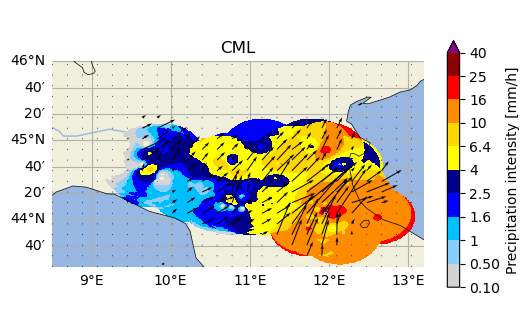

In [9]:
# Plot CML data with the optical flow motion field
from pysteps.visualization import plot_precip_field, quiver

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111); ax.axis("off")
plot_precip_field(
    precip_cml_mmh[index_cml],
    geodata=metadata_cml_mmh,
    title="CML",
    colorscale="STEPS-NL",
    map_kwargs=map_kwargs,
    units="mm/h",
);
quiver(precip_cml_mmh, geodata=metadata_cml_mmh, step=15, quiver_kwargs={"scale": 200});

Step 3: create the nowcasts

In [10]:
# First the CML dataset

# Calculate the S-PROG nowcast for comparison
nowcast_method = nowcasts.get_method("sprog")
precip_cml_sprog = nowcast_method(
    precip_cml_dbr[index_cml-3:index_cml, :, :],
    advection_field_cml,
    timesteps=n_leadtimes,
    n_cascade_levels=6,
    precip_thr=metadata_cml_dbr["threshold"],
)
# Back-transform the results from dBR to rain rates
precip_cml_sprog = transformation.dB_transform(
    precip_cml_sprog,
    threshold=metadata_cml_dbr["threshold"],
    inverse=True
    )[0]

# Then the PWS dataset
# Calculate the S-PROG nowcast for comparison
precip_pws_sprog = nowcast_method(
    precip_pws_dbr[index-3:index, :, :],
    advection_field_pws,
    timesteps=n_leadtimes,
    n_cascade_levels=6,
    precip_thr=metadata_cml_dbr["threshold"],
)
# Back-transform the results from dBR to rain rates
precip_pws_sprog = transformation.dB_transform(
    precip_pws_sprog,
    threshold=metadata_pws_dbr["threshold"],
    inverse=True
    )[0]

Computing S-PROG nowcast
------------------------

Inputs
------
input dimensions: 290x373

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -10.0
Rain fraction is: 0.3849064743767526, while minimum fraction is 0.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.996248      | 0.988447      |
-----------------------------------------
| 2     | 0.917776      | 0.821501      |
-------------------------------------

Step 4: Finally, visualize the results next to the radar-based nowcast and the observations.

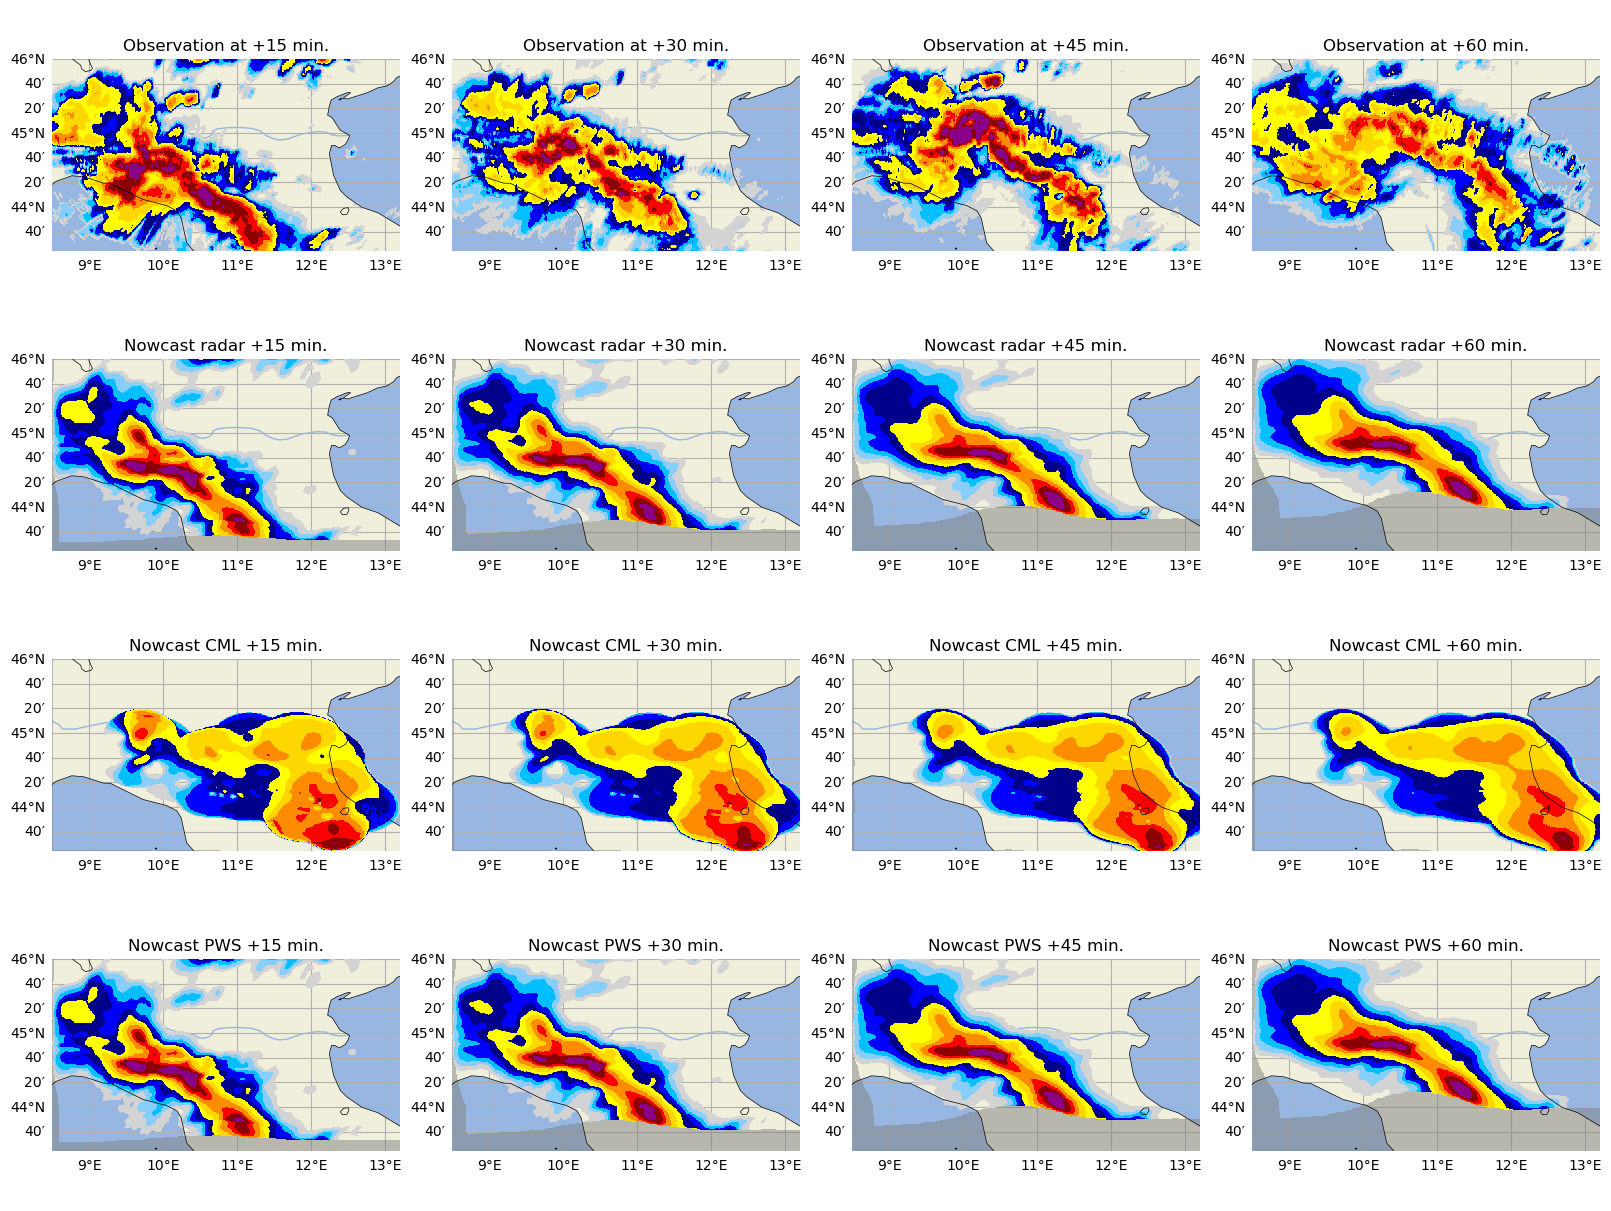

In [11]:
fig = plt.figure(figsize=(16, 12), layout="constrained")
map_kwargs = {"drawlonlatlines": True}

# The nowcasts were made up to 3 hours into the future, so feel free to adjust the plotting
# indices and plot e.g. up to 3 hours instead of up to 1 hour.
for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(4, 4, 1 + i); ax.axis("off")
    plot_precip_field(
        precip_obs_mmh[j],
        geodata=metadata,
        colorscale="STEPS-NL",
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Observation at +{(j + 1) * 15} min."
        )

for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(4, 4, 5 + i); ax.axis("off")
    plot_precip_field(
        precip_sprog[j],
        geodata=metadata,
        colorscale="STEPS-NL",
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Nowcast radar +{(j + 1) * 15} min."
        )

for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(4, 4, 9 + i); ax.axis("off")
    plot_precip_field(
        precip_cml_sprog[j],
        geodata=metadata,
        colorscale="STEPS-NL",
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Nowcast CML +{(j + 1) * 15} min."
        )

for i, j in enumerate(range(0, 4, 1)):
    ax = fig.add_subplot(4, 4, 13 + i); ax.axis("off")
    plot_precip_field(
        precip_pws_sprog[j],
        geodata=metadata,
        colorscale="STEPS-NL",
        colorbar=False,
        map_kwargs=map_kwargs,
        ax=ax,
        title=f"Nowcast PWS +{(j + 1) * 15} min."
        )
